# Determining the background index in the ROI in nEXO
In this Jupyter notebook the number of counts per FWHM per kilogram per year in the region of interest in nEXO is calculated based on the MC PDfs.

### Adjusting cell width

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Importing nEXO packages

In [2]:
import sys
sys.path.append('/g/g99/jamil1/lustre1/sensitivity/modules')

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

### Adjusting the appearance of plots

In [3]:
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', '#F29F05', '#7155D9', 
          '#8D07F6', '#9E91F2', '#F29B9B', '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']

### Defining which components table to read in

In [4]:
input_table = '/p/vast1/nexo/sensitivity2020/pdfs/component_tables/ComponentsTable_D-023_merged-v10b_BkgIndex_Binning.h5'

### Importing the background index from the last sensitivity paper
Number from the 2017 sensitivity paper, gotten from digitizing Figure 8 from https://arxiv.org/abs/1710.05075

In [5]:
Mass2015 = [0.5,1.0,1.5,2.0,2.5,3.0,3.873]
Bkg2015 = [0.000105991,0.000138291,0.000207821,0.000353783,0.000563511,0.000853902,0.00188091]

Mass2017 = [1,2,3,3.648]
Bkg2017 = [0.0003943, 0.0007328, 0.001594, 0.002401]

### Creating the workspace and loading data into the likelihood model

In [6]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace('/p/lustre1/jamil1/sensitivity/work/config/Sensitivity2020_BkgIndex_FineBinning_config.yaml')
workspace.LoadComponentsTableFromFile(input_table)
workspace.CreateGroupedPDFs()

likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs, workspace.histogram_axis_names)
likelihood.model.GenerateModelDistribution()
likelihood.AddDataset(likelihood.model.GenerateDataset())


Loading input data froma previously-generated components table....

Loaded dataframe with 173 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']

Creating grouped PDFs....
no sigma for Rn222_HFE (R-053.9.1.1)
no sigma for Rn222_CathodeRadon (R-088.1.1.1)
no sigma for Rn222_ActiveLXe (R-088.2.1.1)
no sigma for Rn222_InactiveLXe (R-088.3.1.1)

ERROR: No histogram available for K40_OuterCryostatWTSupport

ERROR: No histogram available for Co60_OuterCryostatWTSupport
	Group:                              	Expected Counts:
	Far                                 	      5073.3134
	Vessel_U238                         	     17228.4795
	Vessel_Th232                        	      2748.3922
	FullTPC_Co60             

### Plotting the data

Plotting Far
Plotting VesselU238
Plotting VesselTh232
Plotting FullTPCCo60
Plotting InternalsU238
Plotting InternalsTh232
Plotting FullTPCK40
Plotting Rn222
Plotting B8nu
Plotting FullLXeBb2n
Plotting FullLXeBb0n
Plotting Xe137
Plotting Ar42


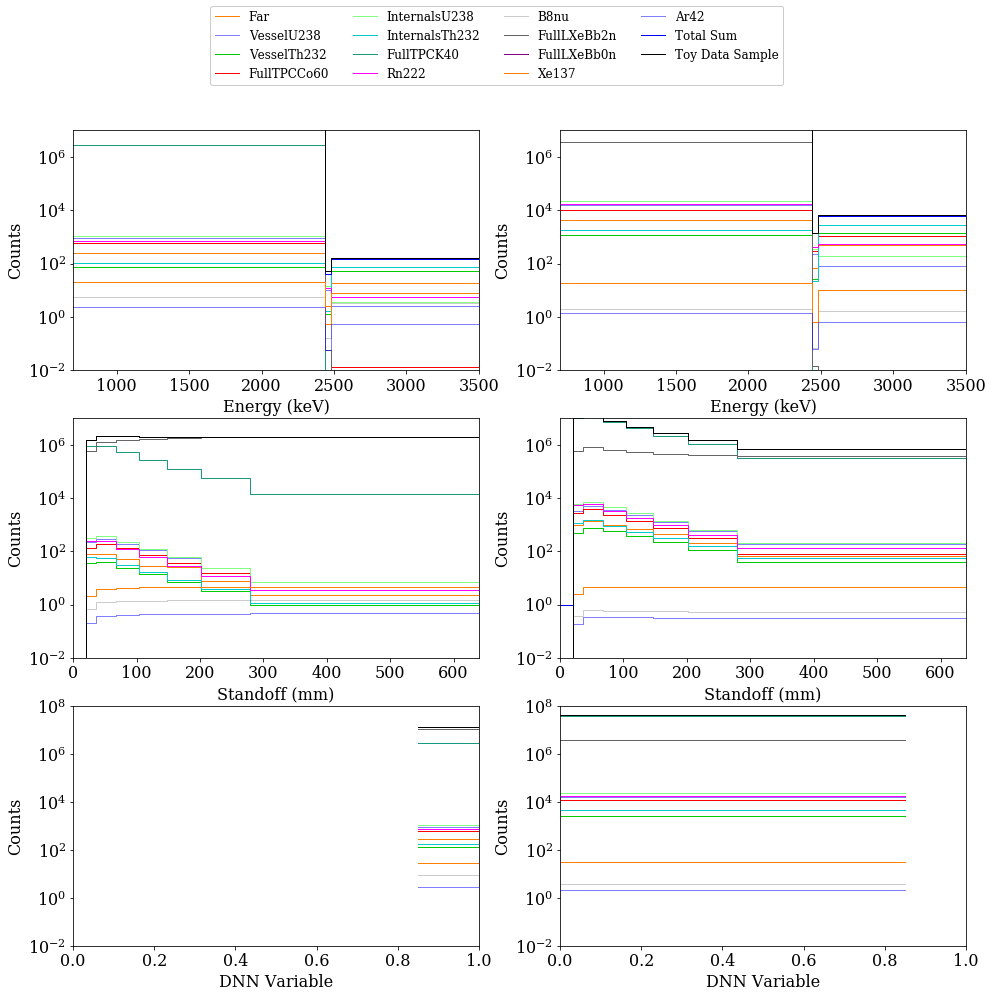

In [7]:
ss_cut_dict = {'DNN': (0.85,1.0), 'Energy (keV)': (0.0,3500.0), 'Standoff (mm)': (0.0,1000.0)}
ms_cut_dict = {'DNN': (0.0,0.85), 'Energy (keV)': (0.0,3500.0), 'Standoff (mm)': (0.0,1000.0)}


likelihood.PlotModelDistributions( ss_cut_dict, ms_cut_dict,\
                                  output_filename='tutorial_input_model_distributions.png',\
                                  save=True,show=True,plot_data=True)

### Defining function to convert a given standoff distance into a fiducial mass

In [8]:
rho_xe = 3.057 # in g/cm^3

tpc_diam = 127.7 # in cm
tpc_height = 118.3 # in cm
ring_gap = 7.185 # in cm

def GetXenonMass(ZStandoff, RStandoff):
    Mass = rho_xe * ( np.pi * (tpc_diam/2.0 - ring_gap - RStandoff)**2 * (tpc_height - 2*ZStandoff) )
    return Mass/1000.0

In [9]:
MassXe = []
Standoff = np.arange(2,50,0.01)
for x in Standoff:
    MassXe.append(GetXenonMass(x,x))
MassXe = np.array(MassXe)

### Finding closest matching standoff distance for each fiducial mass

In [10]:
StandoffVals = []
FiducialMass = [500,1000,1500,2000,2500,3000,3281]

print('Input fiducial mass \t', 'Closest fiducial mass \t', 'Closest standoff distance')
for ii in FiducialMass: 
    Diff = np.abs(MassXe - ii)
    Cut = np.where(Diff == np.min(Diff))[0][0]
    print(ii, '\t\t\t', np.round(MassXe[Cut],2), '\t\t', np.round(Standoff[Cut]*10,2))
    StandoffVals.append(Standoff[Cut]*10)
StandoffVals = np.array(StandoffVals)

Input fiducial mass 	 Closest fiducial mass 	 Closest standoff distance
500 			 500.19 		 278.3
1000 			 999.61 		 201.4
1500 			 1500.4 		 147.3
2000 			 2000.43 		 104.3
2500 			 2500.25 		 68.0
3000 			 2999.51 		 36.3
3281 			 3280.27 		 20.0


### Defining the ROI and calculating the background index

In [11]:
BkgIndex = {}
for ii,FM in enumerate(FiducialMass): 
    roi_dict = { 'DNN':         [0.85,1.],
             'Energy (keV)':  [ 2436,  2480 ], 
             'Standoff (mm)': [ StandoffVals[ii], 1000. ] }
    BkgIndex[FM] = {}
    BkgIndex[FM]['std'] = StandoffVals[ii]
    BkgIndex[FM]['dict'] = roi_dict
    
    workspace.DefineROI(roi_dict)
    
    likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)
    
    sig_idx = likelihood.model.GetVariableIndexByName('Bb0n')
    likelihood.model.variable_list[sig_idx]['Value'] = 0.0
    
    likelihood.model.GenerateModelDistribution()
    bkg_in_roi = likelihood.model.GetIntegralInBinRange(workspace.GetROIBinIndices())

    BkgIndex[FM]['cts'] = bkg_in_roi/FM/10.0    
    print('The background index in the inner most %d kg is %.2e cts/FWHM/kg/yr' % (FM,BkgIndex[FM]['cts']))

DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.85,      1.0
Energy (keV):
	Input ROI boundaries:    2436.0,   2480.0
	Actual ROI boundaries:   2435.2,   2480.5
Standoff (mm):
	Input ROI boundaries:     278.3,   1000.0
	Actual ROI boundaries:    278.3,    650.0
The background index in the inner most 500 kg is 1.20e-04 cts/FWHM/kg/yr
DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.85,      1.0
Energy (keV):
	Input ROI boundaries:    2436.0,   2480.0
	Actual ROI boundaries:   2435.2,   2480.5
Standoff (mm):
	Input ROI boundaries:     201.4,   1000.0
	Actual ROI boundaries:    201.4,    650.0
The background index in the inner most 1000 kg is 2.07e-04 cts/FWHM/kg/yr
DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.85,      1.0
Energy (keV):
	Input ROI boundaries:    2436.0,   2480.0
	Actual ROI boundaries:   2435.2,   2480.5
Standoff (mm):
	Input ROI boundaries:     147.3,   1000.0
	Actual ROI boundari

### Plotting the comparison in background index between 2017 and 2020 model

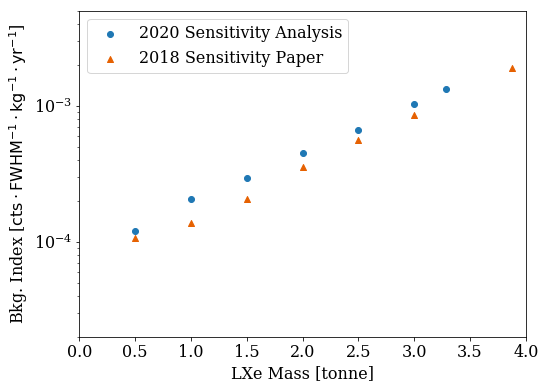

In [12]:
Mass2020 = [x/1000.0 for x in BkgIndex.keys()]
Bkg2020 = [BkgIndex[x]['cts'] for x in BkgIndex.keys()]

plt.figure(figsize=(8,6))
plt.scatter(Mass2020, Bkg2020, color=colors[0], label='2020 Sensitivity Analysis', marker='o')
plt.scatter(Mass2015, Bkg2015, color=colors[1], label='2018 Sensitivity Paper', marker='^')

plt.yscale('log')
plt.xlim(0,4)
plt.ylim(2E-5,5E-3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('LXe Mass [tonne]', fontsize=16)
plt.ylabel(r'Bkg. Index [$\mathrm{cts}\cdot \mathrm{FWHM}^{-1}\cdot \mathrm{kg}^{-1} \cdot \mathrm{yr}^{-1}$]', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.savefig('bkg_index_comparison.png', dpi=300, bbox_inches='tight')

In [13]:
print([float("{0:0.2e}".format(i)) for i in Bkg2020])

[0.00012, 0.000207, 0.000295, 0.000448, 0.00066, 0.00104, 0.00132]
